# **Gemini Pro**

# **Step 1: Libraries**

In [1]:
%pip install google-generativeai --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import re
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import google.generativeai as genai

# **Step 2: Config**

**To get your own Google API key, please click [here](https://ai.google.dev/?gad_source=1&gclid=Cj0KCQjwncWvBhD_ARIsAEb2HW-bcGblMtN9VPLK3B01RYfbvV0SUas4pPIvy44B_Bs84137cDIB2VQaAjYREALw_wcB)**

In [ ]:
os.environ["GOOGLE_API_KEY"] = 'your-google-api-key'

In [ ]:
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# **Step 3: Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# df = pd.read_csv('/content/drive/MyDrive/Medical_Transcription_Extraction/mtsamples.csv')
df = pd.read_csv('mtsamples.csv')

In [ ]:
transcription_list = df['transcription'].to_list()

# **Step 4: Model**

In [ ]:
model = genai.GenerativeModel("gemini-pro")

# **Step 5: Inference**

In [ ]:
# the data point -- Just for test
prompt = f"This is a patient's transcription: '{transcription_list[0]}' \n\n Please use this format as the answer: The patient age is [Your extracted answer]. The patient will get [Your extracted answer] as treatment. Note: If the treatment has already been administered, it's also considered as the treatment, the format will be revised slightly: The patient got [Your extracted answer] as treatment. If there is no specific neither age or treatment , you can return unknown, unknown. If there is no specific age but treatment, you can return unknown, The patient will get [Your extracted answer] as treatment. There may be not only one treatment"
response = model.generate_content(prompt)
print(response.text)

The patient age is 23. The patient will get Zyrtec and Nasonex as treatment.


In [ ]:
def get_gemini_response(transcription):
    prompt = f"This is a patient's transcription: '{transcription}' \n\n Please use this format as the answer: The patient age is [Your extracted answer]. The patient will get [Your extracted answer] as treatment. Note: If the treatment has already been administered, it's also considered as the treatment, the format will be revised slightly: The patient got [Your extracted answer] as treatment. If there is no specific neither age or treatment , you can return unknown, unknown. If there is no specific age but treatment, you can return unknown, The patient will get [Your extracted answer] as treatment. There may be not only one treatment"
    response = model.generate_content(prompt)
    return response.text

In [ ]:
# https://www.analyticsvidhya.com/blog/2023/12/google-gemini-api/

res = []
for transcription in tqdm(transcription_list):
    try:
        response = get_gemini_response(transcription)
        res.append(response)
    except ValueError: # if the prompt is sensitive which is with unsafe queries , return None.
        res.append(None)


In [ ]:
# Save
pd.DataFrame(res).to_csv('/content/drive/MyDrive/Medical_Transcription_Extraction/res.csv', index = False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Medical_Transcription_Extraction/res.csv')

In [ ]:
df['age_treatment'] = data.values

df.to_csv('/content/drive/MyDrive/Medical_Transcription_Extraction/extracted_data.csv', index = False)

In [45]:
# sensitive info, which have got None
null_indices = data[data.isnull().any(axis=1)].index.tolist()
print(null_indices)
print(len(null_indices))

[121, 1286, 1395, 1593, 1759, 1767, 1768, 1770, 1774, 1776, 1779, 1782, 1789, 1791, 1799, 1801, 1803, 1806, 2642, 2795, 2837, 2867, 3075, 3098, 3483, 3815, 3886, 3970, 4156, 4158, 4163, 4167, 4171, 4251, 4285, 4323]
36


# **Step 6: Data Cleaning & Save Result**

## <1> Format Cleaning

In [7]:
data = pd.read_csv('res_gimini.csv')
data['0'][0]

'The patient age is 23 years old. The patient will get Nasonex as treatment.'

In [8]:
# Drop the missing value, reorder the index
data = data.dropna().reset_index(drop=True)

In [9]:
def extract_age_from_description(text):
    if pd.isnull(text) or not isinstance(text, str):
        return None 
    
    age_pattern = r"The patient age is\s+(.+?)[,.]"

    match = re.search(age_pattern, text, re.I)
    if match and match.group(1)!= 'unknown':
        return match.group(1)
    return "not found"

data['age'] = data['0'].apply(extract_age_from_description)
data.head()

,0,age
0,The patient age is 23 years old. The patient w...,23 years old
1,"unknown, unknown",not found
2,The patient age is 42. The patient will get la...,42
3,The patient age is unknown. The patient will g...,not found
4,"The patient age is unknown, The patient will g...",not found


In [10]:
def extract_treatment_from_description(text):
    if pd.isnull(text) or not isinstance(text, str):
        return None 
    
    result = ''
    treatment1_pattern = r'The patient will get\s+(.*?)\s+as treatment'
    treatment2_pattern = r'The patient got\s+(.*?)\s+as treatment'

    match1 = re.search(treatment1_pattern, text, re.I)
    if match1 and match1.group(1)!= 'unknown':
        return 'The patient will get ' + match1.group(1) + ' as treatment.'
    else: result =  "not found"

    match2 = re.search(treatment2_pattern, text, re.I)
    if match2 and match2.group(1)!= 'unknown':
        return  'The patient got ' + match2.group(1) + ' as treatment.'
    else: result =  "not found"

    return result


data['treatment'] = data['0'].apply(extract_treatment_from_description)
data.head()

,0,age,treatment
0,The patient age is 23 years old. The patient w...,23 years old,The patient will get Nasonex as treatment.
1,"unknown, unknown",not found,not found
2,The patient age is 42. The patient will get la...,42,The patient will get laparoscopic Roux-en-Y ga...
3,The patient age is unknown. The patient will g...,not found,not found
4,"The patient age is unknown, The patient will g...",not found,The patient will get mitral valve replacement ...


In [11]:
data = data.iloc[:,1:]
data

,age,treatment
0,23 years old,The patient will get Nasonex as treatment.
1,not found,not found
2,42,The patient will get laparoscopic Roux-en-Y ga...
3,not found,not found
4,not found,The patient will get mitral valve replacement ...
...,...,...
4958,50,not found
4959,14 months old,The patient will get Aspirin high dose 340 mg ...
4960,42,The patient will get Flovent 44 mcg two puffs ...
4961,5-year-old male,The patient will get continuous high-dose albu...


In [14]:
# Save
data.to_csv('res_format_cleaning.csv', index=False)

## <2> Age Data Cleaning

In [15]:
ds = pd.read_csv('res_format_cleaning.csv')
ds['age'].unique()

array(['23 years old', 'not found', '42', '30', '31', '50', '56', '34',
       '17', '37', '67', '66', '55', '74', '77', '82', '4 years old',
       '59', '48', '65 years old', '4', '3-1/2-year-old', '16-month-old',
       '64', '65', '62', '46', '63', '29', '2-1/2-year-old', '71', '75',
       '18', '10', '15', '11-1/2 years old', 'almost 4', '8-year-old boy',
       '2 years old', '49', '16 years old', '7', '9-year-old', '60', '53',
       '14-1/2-year-old', '5-year-old', '17 months old',
       '1 year and 6 months', '6 months', '85', '77-year-old', '72', '61',
       '76', '68', '79', '70', '4-1/2-year-old', '84', '78',
       '61-year-old female', 'newborn', '43 years', '34 years old',
       '3-year-old', '57', '11 months', '79 years old', '27', '73', '51',
       '69', '52', '26-year-old', '2-month-old infant', '87', '36', '92',
       '41', '21', '1 year old', '35', '86', '4 months old', 'XX', '54',
       '58', '40', '9', '5-1/2 years old', '47', '81', '32', '44', '45',
      

In [16]:
ds['age'].value_counts()

age
not found       2162
51                62
50                60
55                53
62                52
                ... 
1+ year            1
5 months old       1
66 years old       1
12 years old       1
six                1
Name: count, Length: 426, dtype: int64

In [17]:
def format_age(age):
    # Check if the entry is a single word without spaces
    if isinstance(age, str) and age.isdigit():
        return f"{age} years old"
    else:
        return age

ds['age'] = ds['age'].apply(format_age)

In [18]:
ds['age'].value_counts()

age
not found             2162
51 years old            63
50 years old            63
55 years old            56
62 years old            55
                      ... 
3-week-old               1
1-month-26-day-old       1
10 days                  1
4-day-old                1
six                      1
Name: count, Length: 359, dtype: int64

In [19]:
def convert_age_descriptions(data_list):
    converted_data = []

    correct_format_pattern = r'\b(\d+|one plus)(-year-old|-years old|-month-old|-months old|-week-old|-weeks old|-day-old|-days old)\b|neonatal|new born|middle-aged|toddler'

    extra_suffix_pattern = r'(\d+)-(year|month|week|day)-old\b.*'
    
    missing_old_pattern = r'(\d+|1\s+and\s+1/7th|\d+\s+and\s+1/7th)( years| months| weeks| days)\b(?!\s*old)'

    other_way_pattern = r'(\d+)(y/o|y/oRHF| y/o|yrs| yrs|yo| yo| year\(s\)|y| years oldRHF)'

    wrong_information_phrases = {
        "5 feet tall and currently weighs 110 pounds",
        "unknown The patient will get Repeat exam in five years if adenomatous",
        "600 grams",
        "missing",
        "1812g",
        "1812 g",
        "80 The patient will get IV antibiotics"
    }

    unknown_pattern = r'\*\*|XX|\b1\+|almost|six|2-1/2|14-1/2|\b60\b|11-1/2|4-1/2'

    for text in data_list:
        # Direct comparison for wrong information
        if text in wrong_information_phrases:
            converted_data.append('not found')
            continue  # Move to the next item immediately
        # Check if text matches correct format
        elif re.search(correct_format_pattern, text):
            converted_data.append(text)
        # Process extra suffixes, removing anything after 'old'
        elif re.search(extra_suffix_pattern, text):
            corrected = re.sub(extra_suffix_pattern, r'\1-\2-old', text)
            converted_data.append(corrected)
        # Add 'old' where missing
        elif re.search(missing_old_pattern, text):
            corrected = re.sub(missing_old_pattern, r'\1\2 old', text)
            converted_data.append(corrected)
        # Convert abbreviations and variations to 'X years old'
        elif re.search(other_way_pattern, text):
            corrected = re.sub(other_way_pattern, r'\1 years old', text)
            converted_data.append(corrected)
        # Tag unknown or ambiguous information
        elif re.search(unknown_pattern, text):
            converted_data.append('unknown')
        # Retain original text if no conditions are met
        else:
            converted_data.append(text)

    return converted_data

ds['converted_age'] = convert_age_descriptions(ds['age'])
ds['converted_age']

0          23 years old
1             not found
2          42 years old
3             not found
4             not found
             ...       
4958       50 years old
4959      14 months old
4960       42 years old
4961    5-year-old male
4962       34 years old
Name: converted_age, Length: 4963, dtype: object

In [20]:
ds['converted_age'].value_counts().to_csv('value_counts.csv', index=False)

In [21]:
ds.to_csv('res_age_cleaning.csv', index=False)

## <3> Get the Final Result

In [30]:
d = pd.read_csv('res_age_cleaning.csv')
d

,age,treatment,converted_age
0,23 years old,The patient will get Nasonex as treatment.,23 years old
1,not found,not found,not found
2,42 years old,The patient will get laparoscopic Roux-en-Y ga...,42 years old
3,not found,not found,not found
4,not found,The patient will get mitral valve replacement ...,not found
...,...,...,...
4958,50 years old,not found,50 years old
4959,14 months old,The patient will get Aspirin high dose 340 mg ...,14 months old
4960,42 years old,The patient will get Flovent 44 mcg two puffs ...,42 years old
4961,5-year-old male,The patient will get continuous high-dose albu...,5-year-old male


In [31]:
d['age']=d['converted_age']
d = d.iloc[:,:2]
d

,age,treatment
0,23 years old,The patient will get Nasonex as treatment.
1,not found,not found
2,42 years old,The patient will get laparoscopic Roux-en-Y ga...
3,not found,not found
4,not found,The patient will get mitral valve replacement ...
...,...,...
4958,50 years old,not found
4959,14 months old,The patient will get Aspirin high dose 340 mg ...
4960,42 years old,The patient will get Flovent 44 mcg two puffs ...
4961,5-year-old male,The patient will get continuous high-dose albu...


In [32]:
d.to_csv('result.csv', index=False)

# **Step 7: Data Visualization**

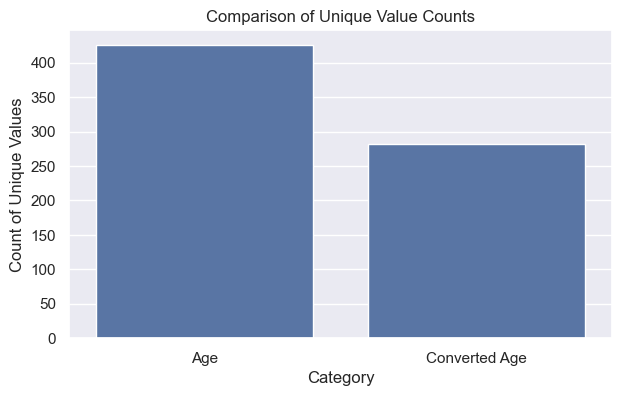

In [34]:
age_count_size = 426  # ds['age'].value_counts().size
converted_age_count_size = 282  # ds['converted_age'].value_counts().size

data = {
    'Category': ['Age', 'Converted Age'],
    'Unique Values': [age_count_size, converted_age_count_size]
}
dd = pd.DataFrame(data)

# Creating the bar plot
plt.figure(figsize=(7, 4))
sns.barplot(x='Category', y='Unique Values', data=dd)
plt.title('Comparison of Unique Value Counts')
plt.xlabel('Category')
plt.ylabel('Count of Unique Values')
plt.show()